In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#load the mnist dataset
mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

mnist_train.data = mnist_train.data[:5000]
mnist_train.targets = mnist_train.targets[:5000]

#create validation set
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [4000, 1000])

mnist_test.data = mnist_test.data[:500]
mnist_test.targets = mnist_test.targets[:500]


In [3]:
#create train and test loaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=20, shuffle=False)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=20, shuffle=False)

In [4]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [5]:
#create a cnn architecture
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [6]:
#create the model
model = CNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model_loss = nn.CrossEntropyLoss()
model.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
def train_model(model, device, model_loss, optimizer, train_loader, val_loader, epochs=10):
    temp = 1
    
    validation_losses = []
    validation_accuracies = []
    
    train_losses = []
    train_accuracies = []
    
    # Training loop
    for epoch in range(epochs):
        
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)

            # Softmax with temperature
            output = output / temp
            output = F.log_softmax(output, dim=1)

            loss = model_loss(output, target)
            
            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()
            
            loss.backward()
            optimizer.step()

        # Validation loop
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            model.eval()
            for batch_idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                output = output / temp
                output = F.log_softmax(output, dim=1)
                loss = model_loss(output, target)
                val_loss += loss.item()
                _, predicted = output.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

        val_loss /= len(val_loader)
        train_loss /= len(train_loader)
        train_accuracy = 100. * train_correct / train_total
        accuracy = 100. * correct / total
        print('Epoch: {} Train Set: Average loss: {:.4f}, Validation set: Average loss: {:.4f}, Train Accuracy: {}/{} ({:.2f}%), Val Accuracy: {}/{} ({:.2f}%)'.format(
            epoch + 1, train_loss, val_loss, train_correct, train_total, train_accuracy, correct, total, accuracy))
        
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(val_loss)
        validation_accuracies.append(accuracy)
        
        # scheduler.step(val_loss)
        
    return train_losses, validation_losses

In [8]:
#train the teacher model
traing_accs, test_accs = train_model(model, device, model_loss, optimizer, train_loader, val_loader, 20)

/Users/loganfalzarano/anaconda3/envs/mlma/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Train Set: Average loss: 0.8270, Validation set: Average loss: 0.2436, Train Accuracy: 2964/4000 (74.10%), Val Accuracy: 923/1000 (92.30%)
Epoch: 2 Train Set: Average loss: 0.1666, Validation set: Average loss: 0.1460, Train Accuracy: 3802/4000 (95.05%), Val Accuracy: 953/1000 (95.30%)
Epoch: 3 Train Set: Average loss: 0.0804, Validation set: Average loss: 0.1402, Train Accuracy: 3902/4000 (97.55%), Val Accuracy: 949/1000 (94.90%)
Epoch: 4 Train Set: Average loss: 0.0431, Validation set: Average loss: 0.1276, Train Accuracy: 3946/4000 (98.65%), Val Accuracy: 957/1000 (95.70%)
Epoch: 5 Train Set: Average loss: 0.0171, Validation set: Average loss: 0.1585, Train Accuracy: 3983/4000 (99.58%), Val Accuracy: 955/1000 (95.50%)
Epoch: 6 Train Set: Average loss: 0.0099, Validation set: Average loss: 0.1427, Train Accuracy: 3989/4000 (99.72%), Val Accuracy: 963/1000 (96.30%)
Epoch: 7 Train Set: Average loss: 0.0069, Validation set: Average loss: 0.1900, Train Accuracy: 3991/4000 (99.78

In [9]:
#define attack methods
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  alpha = epsilon/iter
  pert_out = input
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def pgd_attack(input,epsilon,data_grad):
  iter=10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    pert_out = torch.min(torch.max(pert_out, input - epsilon), input + epsilon)
  return pert_out


In [10]:
def create_adversarial_dataset(model, device, data_loader, attack, epsilon):
    
    #check batch size of data loader
    if data_loader.batch_size != 1:
        data_loader = torch.utils.data.DataLoader(data_loader.dataset, batch_size=1, shuffle=False)
    
    adv_images = []
    targets = []
    correct = 0
    total = 0
    for data, target in data_loader:
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = attack(data, epsilon, data_grad)
        
        adv_images.append(perturbed_data)
        targets.append(target)
    #convert list to tensor
    adv_images = torch.cat(adv_images)
    targets = torch.cat(targets)
    adv_dataset = torch.utils.data.TensorDataset(adv_images, targets)
    return adv_dataset

In [11]:
def visualize_samples_from_dataset(dataset, num_samples):
    fig, axs = plt.subplots(1, num_samples, figsize=(20, 20))
    for i in range(num_samples):
        axs[i].imshow(dataset[i][0].detach().cpu().numpy().squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.show()

In [12]:
def evaluate_model(data_loader, model, loss_fn, device):
    model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += loss_fn(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    return loss / len(data_loader), 100 * correct / total

In [13]:
def evaluate_model_for_epsilons(model, loss_fn, attack_fn, epsilons):
    results = []
    epsilon_to_images = {}
    for epsilon in epsilons:
        adv_dataset = create_adversarial_dataset(model, device, test_loader, attack_fn, epsilon)
        #take first image from the dataset
        epsilon_to_images[epsilon] = adv_dataset[0][0]
        adv_loader = torch.utils.data.DataLoader(adv_dataset, batch_size=20, shuffle=False)
        loss, accuracy = evaluate_model(adv_loader, model, loss_fn, device)
        results.append((epsilon, accuracy))
    return results, epsilon_to_images

In [14]:
def evaluate_model_on_all_attacks(model, loss_fn, epsilons, plot=True):
    fgsm_results, fgsm_epsilon_to_image = evaluate_model_for_epsilons(model, loss_fn, fgsm_attack, epsilons)
    ifgsm_results, ifgsm_epsilon_to_image = evaluate_model_for_epsilons(model, loss_fn, ifgsm_attack, epsilons)
    mifgsm_results, mifgsm_epsilon_to_image = evaluate_model_for_epsilons(model, loss_fn, mifgsm_attack, epsilons)
    pgd_results, pgd_epsilon_to_image = evaluate_model_for_epsilons(model, loss_fn, pgd_attack, epsilons)
    
    perturbed_datasets = {
        'fgsm':fgsm_epsilon_to_image, 
        'ifgsm':ifgsm_epsilon_to_image, 
        "mifgsm":mifgsm_epsilon_to_image, 
        'pgd':pgd_epsilon_to_image
                          }
    results_list = [fgsm_results, ifgsm_results, mifgsm_results]
    
    if plot:
        #plot all 3 on the same graph
        plt.figure(figsize=(10, 5))
        plt.plot([x[0] for x in fgsm_results], [x[1] for x in fgsm_results], label='FGSM')
        plt.plot([x[0] for x in ifgsm_results], [x[1] for x in ifgsm_results], label='IFGSM')
        plt.plot([x[0] for x in mifgsm_results], [x[1] for x in mifgsm_results], label='MIFGSM')
        plt.plot([x[0] for x in pgd_results], [x[1] for x in pgd_results], label='PGD')
        
        plt.xlabel('Epsilon')
        plt.ylabel('Accuracy')
        plt.title('Accuracy vs Epsilon')
        plt.legend()
        plt.show()
    
    return results_list, perturbed_datasets

tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')


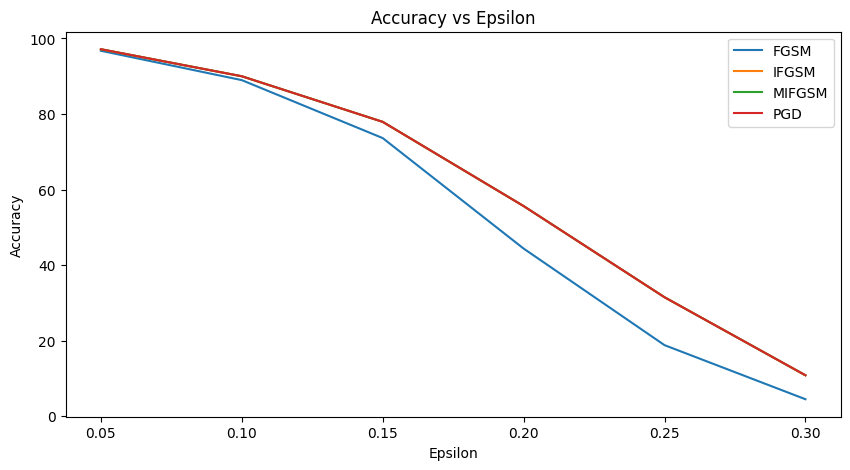

In [15]:
results, attack_to_epislon_to_image = evaluate_model_on_all_attacks(model, model_loss, [0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

In [16]:
def vizualize_images_for_model(attack_to_epislon_to_image):
    fig, axs = plt.subplots(4, 6, figsize=(20, 10))
    for i, (attack, epsilon_to_image) in enumerate(attack_to_epislon_to_image.items()):
        for j, (epsilon, image) in enumerate(epsilon_to_image.items()):
            axs[i, j].imshow(image.detach().cpu().numpy().squeeze(), cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_title(f'{attack} Epsilon: {epsilon}')
    plt.show()

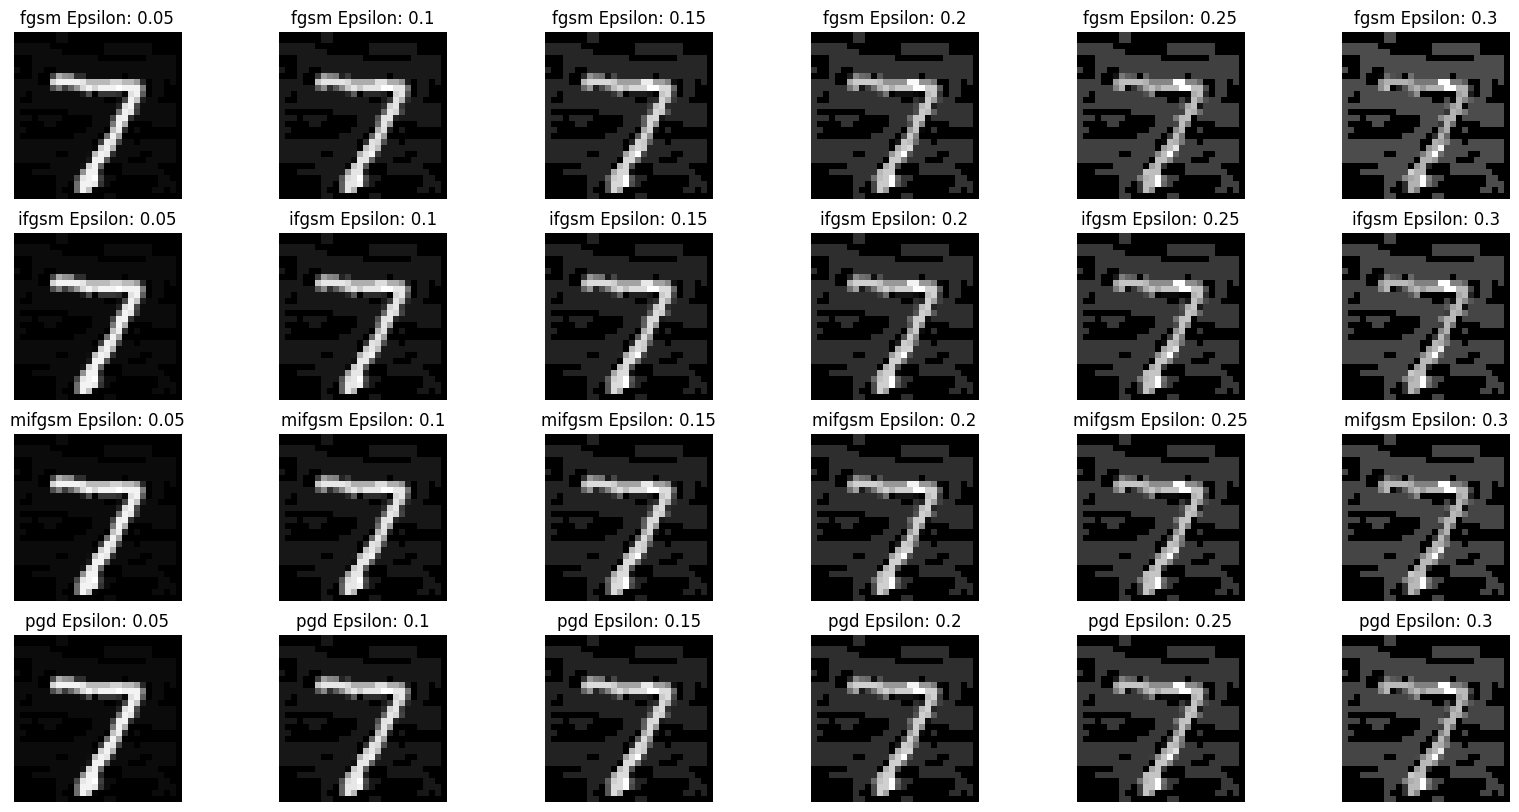

In [17]:
vizualize_images_for_model(attack_to_epislon_to_image)

##### Clearly we can see that these adverarial methods are causing our model to perform poorly. We can see that the model is not able to predict the correct class for the adversarial images. This is a clear indication that the model is not robust to these attacks. Let's see how we can improve the robustness of the model using adversarial training.

In [18]:
#get the four adversarial datasets
fgsm_dataset = create_adversarial_dataset(model, device, test_loader, fgsm_attack, 0.1)
ifgsm_dataset = create_adversarial_dataset(model, device, test_loader, ifgsm_attack, 0.1)
mifgsm_dataset = create_adversarial_dataset(model, device, test_loader, mifgsm_attack, 0.1)
pgf_dataset = create_adversarial_dataset(model, device, test_loader, pgd_attack, 0.1)

tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')


In [19]:
def create_adversarial_training_data_loader(model, device, data_loader, attack, epsilons):
    #create on big dataset with all the adversarial examples
    images = []
    targets = []
    for epsilon in epsilons:
        adv_dataset = create_adversarial_dataset(model, device, data_loader, attack, epsilon)
        images.append(adv_dataset.tensors[0])
        targets.append(adv_dataset.tensors[1])
    images = torch.cat(images)
    targets = torch.cat(targets)
    adv_dataset = torch.utils.data.TensorDataset(images, targets)
    return adv_dataset

In [20]:
fgsm_train_set = create_adversarial_training_data_loader(model, device, train_loader, fgsm_attack, [0.05, 0.1, 0.15, 0.2])

tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')


In [40]:
#print first 5 iamges from the dataloader
images_list = []
labels_list = []

counter = 0 
for data, target in fgsm_train_set:
    images_list.append(data.detach().cpu().numpy())
    labels_list.append(target.detach().cpu().numpy())
    

    


In [ ]:
#convert lists to numpy arrays
images_list = np.array(images_list)
labels_list = np.array(labels_list)

#get 4000 random indices from 0 16000
random_indices = np.random.choice(16000, 4000, replace=False)

#select 4000 random images
images_list = images_list[random_indices]
labels_list = labels_list[random_indices]

In [53]:
#get data from data subset minst_train
training_set_numpy_images = mnist_train.dataset.data.numpy()
training_set_numpy_labels = mnist_train.dataset.targets.numpy()

#add dimensions to the images
training_set_numpy_images = np.expand_dims(training_set_numpy_images, axis=1)



In [54]:
#concatenate together

#print the dimensions fo all the arrays
print(images_list.shape)
print(labels_list.shape)
print(training_set_numpy_images.shape)
print(training_set_numpy_labels.shape)


(4000, 1, 28, 28)
(4000,)
(5000, 1, 28, 28)
(5000,)


In [55]:
#concatenate the images and labels
images = np.concatenate((images_list, training_set_numpy_images), axis=0)
labels = np.concatenate((labels_list, training_set_numpy_labels), axis=0)

In [56]:
#create new dataset
adversarial_train_set = torch.utils.data.TensorDataset(torch.tensor(images), torch.tensor(labels))

9000


In [58]:
#create a dataloader
new_loader = torch.utils.data.DataLoader(adversarial_train_set, batch_size=20, shuffle=True)

In [59]:
#create a new model
fgsm_robust_model = CNN().to(device)
optimizer = optim.Adam(fgsm_robust_model.parameters(), lr=0.001)
model_loss = nn.CrossEntropyLoss()

#train the robust model
traing_accs, test_accs = train_model(fgsm_robust_model, device, model_loss, optimizer, new_loader, val_loader, 20)

/Users/loganfalzarano/anaconda3/envs/mlma/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Train Set: Average loss: 1.3100, Validation set: Average loss: 0.6943, Train Accuracy: 5782/9000 (64.24%), Val Accuracy: 831/1000 (83.10%)
Epoch: 2 Train Set: Average loss: 0.1599, Validation set: Average loss: 0.4759, Train Accuracy: 8643/9000 (96.03%), Val Accuracy: 868/1000 (86.80%)
Epoch: 3 Train Set: Average loss: 0.0606, Validation set: Average loss: 0.4819, Train Accuracy: 8862/9000 (98.47%), Val Accuracy: 871/1000 (87.10%)
Epoch: 4 Train Set: Average loss: 0.0516, Validation set: Average loss: 0.4312, Train Accuracy: 8878/9000 (98.64%), Val Accuracy: 881/1000 (88.10%)
Epoch: 5 Train Set: Average loss: 0.0481, Validation set: Average loss: 0.5093, Train Accuracy: 8901/9000 (98.90%), Val Accuracy: 850/1000 (85.00%)
Epoch: 6 Train Set: Average loss: 0.0265, Validation set: Average loss: 0.4582, Train Accuracy: 8939/9000 (99.32%), Val Accuracy: 861/1000 (86.10%)
Epoch: 7 Train Set: Average loss: 0.0545, Validation set: Average loss: 0.5607, Train Accuracy: 8898/9000 (98.87

In [62]:
#evaluate the model for epsilon 0.1
results, attack_to_epislon_to_image = evaluate_model_on_all_attacks(fgsm_robust_model, model_loss, [0.05, 0.1, 0.2], plot=False)

/Users/loganfalzarano/anaconda3/envs/mlma/lib/python3.10/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')
tensor(7, device='mps:0')


In [63]:
print(results)

[[(0.05, 0.7633587786259542), (0.1, 0.5089058524173028), (0.2, 0.0)], [(0.05, 1.7811704834605597), (0.1, 0.2544529262086514), (0.2, 0.0)], [(0.05, 1.7811704834605597), (0.1, 0.2544529262086514), (0.2, 0.0)]]


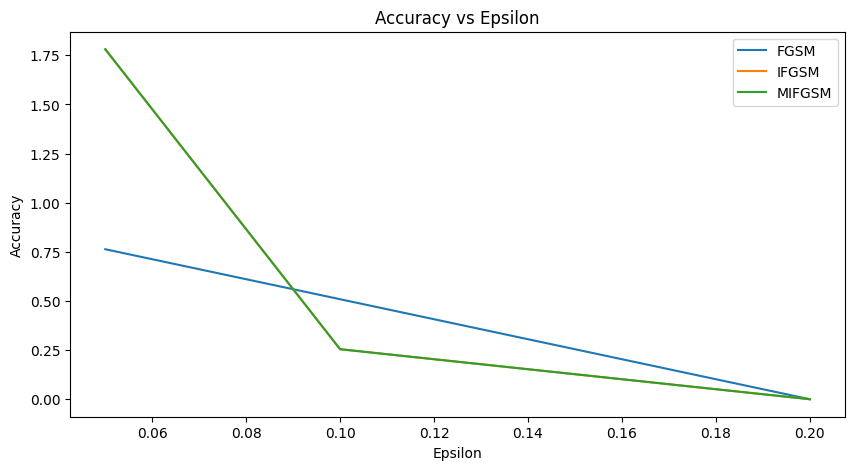

In [65]:
#plot the results
plt.figure(figsize=(10, 5))
plt.plot([x[0] for x in results[0]], [x[1] for x in results[0]], label='FGSM')
plt.plot([x[0] for x in results[1]], [x[1] for x in results[1]], label='IFGSM')
plt.plot([x[0] for x in results[2]], [x[1] for x in results[2]], label='MIFGSM')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epsilon')
plt.legend()


In [68]:
def test( model, device, test_loader, epsilon ):
    if test_loader.batch_size != 1:
        test_loader = torch.utils.data.DataLoader(test_loader.dataset, batch_size=1, shuffle=False)

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [70]:
accuracies = []
examples = []

epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(fgsm_robust_model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 393 / 500 = 0.786
Epsilon: 0.05	Test Accuracy = 3 / 500 = 0.006
Epsilon: 0.1	Test Accuracy = 2 / 500 = 0.004
Epsilon: 0.15	Test Accuracy = 0 / 500 = 0.0
Epsilon: 0.2	Test Accuracy = 0 / 500 = 0.0
Epsilon: 0.25	Test Accuracy = 0 / 500 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 500 = 0.0


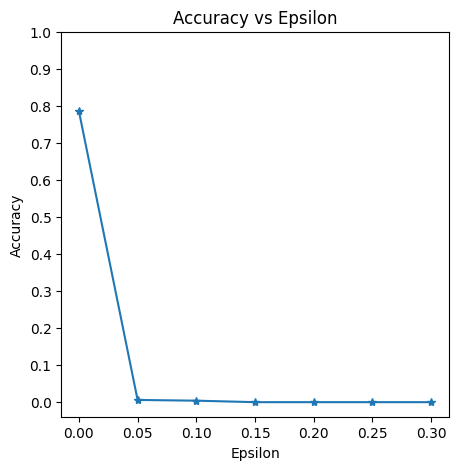

In [72]:
#plot these epsilon accuracies
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


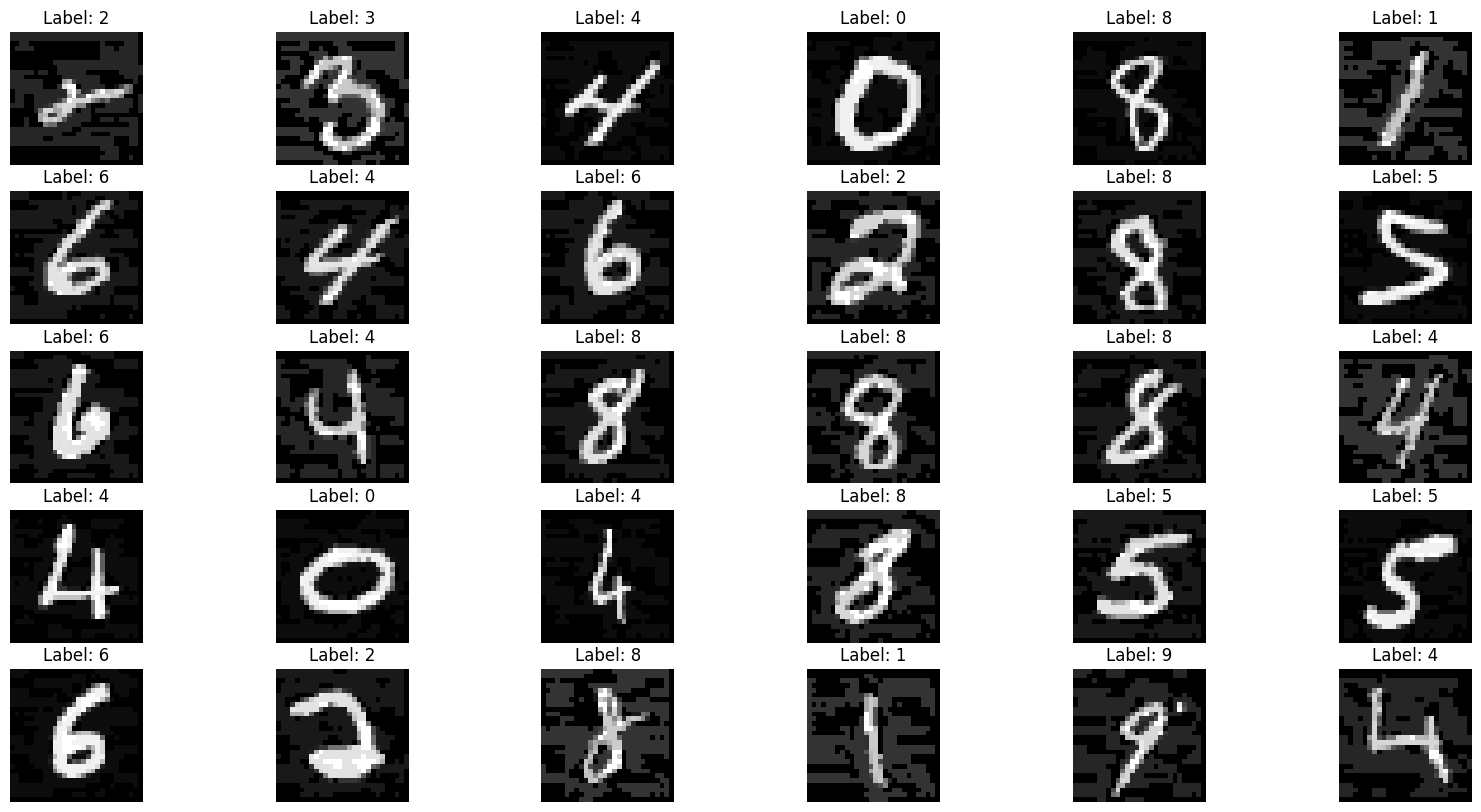

In [71]:
#verify images from new loader

#randomly plot 30 images from the new loader
fig, axs = plt.subplots(5, 6, figsize=(20, 10))
for i in range(5):
    for j in range(6):
        image, label = new_loader.dataset[i*6+j]
        axs[i, j].imshow(image.detach().cpu().numpy().squeeze(), cmap='gray')
        axs[i, j].axis('off')
        axs[i, j].set_title(f'Label: {label.item()}')